# Extra examples
We work through several more examples in this worksheet: mixture of Gaussians and maxcut. See [the basic worksheet](polynomial_optimization.ipynb) for setups, references, and simpler examples.

In [1]:
# we are dependent on numpy, sympy and cvxopt.
import numpy as np
import cvxopt
import mompy as mp

# just some basic settings and setup
mp.cvxsolvers.options['show_progress'] = False
from IPython.display import display, Markdown, Math, display_markdown
sp.init_printing()

def print_problem(obj, constraints = None, moment_constraints = None):
    display_markdown(mp.problem_to_str(obj,constraints,moment_constraints, False), raw=True)

## Noiseless mixture of 2 Gaussians in 1D

This is original problem considered by Pearson, and we will solve it as an optimization problem.

K. Pearson. Contributions to the mathematical theory of evolution. Philosophical Transactions of the Royal Society of London. A, 185:71–110, 1894.

We have two Gaussians with means $\xi_1, \xi_2$ and variances $c_1, c_2$, mixing coefficients $\pi_1, \pi_2$. So that $x \sim \pi_1 p(x; \xi_1, c_1) + \pi_2 p(x; \xi_2, c_2)$ where $p$ is the density function of the normal distribution.

More details can be found in our paper: [Estimating mixture models via mixtures of polynomials](http://papers.nips.cc/paper/5702-estimating-mixture-models-via-mixtures-of-polynomials.pdf).


In [2]:
xi,c = sp.symbols('xi,c')
K = 2 # number of clusters
xi0 = [1, -0.9] # true parameters
c0 = [0.4, 0.6]
pi0 = [0.4, 0.6]

moment_exprs = [xi, xi**2 + c, xi**3 + 3*xi*c, xi**4 + 6*xi**2 * c + 3*c**2,\
          xi**5 + 10*xi**3*c + 15*xi*c**2,\
          xi**6 + 15*xi**4*c**1 + 45*xi**2*c**2  + 15*c**3 ,\
          xi**7 + 21*xi**5*c**1 + 105*xi**3*c**2  + 105*xi*c**3]
moment_exprs = moment_exprs[0:6]
#print 'Gaussian moments are '
display(moment_exprs)

# construct the true constraints
hs = []
for expr in moment_exprs:
    val = 0
    for k in range(K):
        val += pi0[k]*expr.subs({xi:xi0[k], c:c0[k]})
    hs += [expr - val]
hs_true = hs
# we will minimize some kind of a trace..
f = 1 + xi**2 + c + c**2 + xi**4 + c*xi**2
gs = [c>=0]
print_problem(f, gs, hs)
sol = mp.solvers.solve_GMP(f, gs, hs, rounds = 2, slack=1e-3)
display(mp.extractors.extract_solutions_lasserre(sol['MM'], sol['x'], 2, tol = 1e-5, maxdeg=2))
print 'the truth: ' + str({c:c0, xi:xi0})

Minimizing $\mathcal{L}(c^{2} + c \xi^{2} + c + \xi^{4} + \xi^{2} + 1)$

subject to 	 $c \geq 0$, 	
$\mathcal{L}(\xi + 0.14) = 0$, 	$\mathcal{L}(c + \xi^{2} - 1.406) = 0$, 	$\mathcal{L}(3 c \xi + \xi^{3} + 0.5294) = 0$, 	$\mathcal{L}(3 c^{2} + 6 c \xi^{2} + \xi^{4} - 4.34326) = 0$, 	$\mathcal{L}(15 c^{2} \xi + 10 c \xi^{3} + \xi^{5} + 2.934694) = 0$, 	$\mathcal{L}(15 c^{3} + 45 c^{2} \xi^{2} + 15 c \xi^{4} + \xi^{6} - 19.7430046) = 0$, 	

the maximum degree appearing in the problem is 4
slacks
0.001
status: optimal
round=1,	 rank=4,	 size=6,	 obj=3.929
slacks
0.001
status: optimal
round=2,	 rank=4,	 size=10,	 obj=3.931


{c: array([ 0.40002654,  0.5999915 ]), xi: array([ 0.9999003 , -0.89989815])}

the truth: {c: [0.4, 0.6], xi: [1, -0.9]}


In [3]:
sol['MM'].numeric_instance(sol['x'],1)

array([[ 1.        ,  0.52000032, -0.14      ],
       [ 0.52000032,  0.28000039, -0.16399987],
       [-0.14      , -0.16399987,  0.88599968]])

## Noisy mixture of Gaussian

Now we draw a bunch of samples, and repeat the above experiment. 

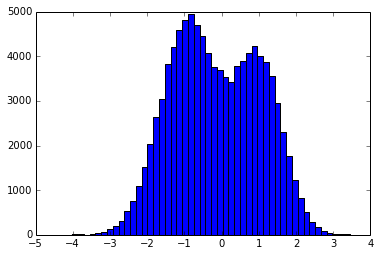

In [4]:
# draw some samples
numsample = 1e5
np.random.seed(1)
z = (np.random.rand(numsample) < pi0[0]).astype('int8')
means = xi0[0]*z + xi0[1]*(1-z)
stds = np.sqrt(c0[0]*z + c0[1]*(1-z))
Xs = means + stds * np.random.randn(numsample)

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Xs, 50);

In [5]:
# construct the empirical constraints
hs = []
for d,expr in enumerate(moment_exprs):
    val = np.mean(np.power(Xs,d+1))
    hs += [expr - val]
    
# we will minimize some kind of a trace..
f = 1 + xi**2 + c + c**2 + xi**4 + c*xi**2
gs = [c>=0.1]
print_problem(f, gs, hs)
sol = mp.solvers.solve_GMP(f, gs, hs, rounds = 4, slack = 1e-5)
display(mp.extractors.extract_solutions_lasserre(sol['MM'], sol['x'], 2, tol = 1e-5, maxdeg=2))
print 'the truth: ' + str({c:c0, xi:xi0})

Minimizing $\mathcal{L}(c^{2} + c \xi^{2} + c + \xi^{4} + \xi^{2} + 1)$

subject to 	 $c \geq 0.1$, 	
$\mathcal{L}(\xi + 0.133161603900389) = 0$, 	$\mathcal{L}(c + \xi^{2} - 1.40251833763525) = 0$, 	$\mathcal{L}(3 c \xi + \xi^{3} + 0.496987978395773) = 0$, 	$\mathcal{L}(3 c^{2} + 6 c \xi^{2} + \xi^{4} - 4.30027499330449) = 0$, 	$\mathcal{L}(15 c^{2} \xi + 10 c \xi^{3} + \xi^{5} + 2.72610631699892) = 0$, 	$\mathcal{L}(15 c^{3} + 45 c^{2} \xi^{2} + 15 c \xi^{4} + \xi^{6} - 19.3575469937392) = 0$, 	

the maximum degree appearing in the problem is 4
slacks
1e-05
status: optimal
round=1,	 rank=4,	 size=6,	 obj=3.920
slacks
1e-05
status: optimal
round=2,	 rank=4,	 size=10,	 obj=3.921
slacks
1e-05
status: optimal
round=3,	 rank=8,	 size=15,	 obj=3.921
slacks
1e-05
status: optimal
round=4,	 rank=13,	 size=21,	 obj=3.921


{c: array([ 0.40670633,  0.58659616]), xi: array([ 0.99241976, -0.9023739 ])}

the truth: {c: [0.4, 0.6], xi: [1, -0.9]}


## PSD max-cut
This is the problem $\text{minimize} -x^T W x$ subject to constraints $x_i \in \{-1,1\}$ for a positive definite random matrix $W$.

In [6]:
size = 5
np.random.seed(1)
xs = sp.symbols('x1:'+str(size+1))
Wh = np.random.randn(size,size)
W = -Wh*Wh.T;
gs = [x**2 >=1 for x in xs] + [x**2 <=1 for x in xs]
fs = [ w * xs[ij[0]] * xs[ij[1]]  for ij,w in np.ndenumerate(W) ]
f = sum(fs)
print_problem(f, gs)

sol = mp.solvers.solve_GMP(f, gs, rounds = 3)
mp.extractors.extract_solutions_lasserre(sol['MM'], sol['x'], 2, maxdeg = 2)

Minimizing $\mathcal{L}(- 2.63849786045427 x_{1}^{2} - 2.8159621181607 x_{1} x_{2} + 1.5444882222147 x_{1} x_{3} - 2.36029763522308 x_{1} x_{4} + 1.90496846588222 x_{1} x_{5} - 3.04436809254823 x_{2}^{2} - 3.13638664976909 x_{2} x_{3} + 0.110022678943274 x_{2} x_{4} + 0.570920362681197 x_{2} x_{5} - 0.103952853443888 x_{3}^{2} - 0.674290696370057 x_{3} x_{4} - 2.0443920170026 x_{3} x_{5} - 0.00178200041176822 x_{4}^{2} - 0.585722691036166 x_{4} x_{5} - 0.811541441325085 x_{5}^{2})$

subject to 	 $x_{1}^{2} \geq 1$, 	 $x_{2}^{2} \geq 1$, 	 $x_{3}^{2} \geq 1$, 	 $x_{4}^{2} \geq 1$, 	 $x_{5}^{2} \geq 1$, 	 $x_{1}^{2} \leq 1$, 	 $x_{2}^{2} \leq 1$, 	 $x_{3}^{2} \leq 1$, 	 $x_{4}^{2} \leq 1$, 	 $x_{5}^{2} \leq 1$, 	


the maximum degree appearing in the problem is 2
slacks
1e-06
status: optimal
round=1,	 rank=3,	 size=6,	 obj=-15.740
slacks
1e-06
status: optimal
round=2,	 rank=18,	 size=21,	 obj=-15.740
slacks
1e-06
status: optimal
round=3,	 rank=37,	 size=56,	 obj=-14.087
lost 0.0000002


{x5: array([ 0.99999999, -0.99999999]),
 x3: array([ 1., -1.]),
 x4: array([ 0.99999999, -0.99999999]),
 x1: array([ 0.99999999, -0.99999999]),
 x2: array([ 1., -1.])}